In [103]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

In [107]:
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")


In [108]:
# Data augmentation and normalization for training
# Just normalization for validation
train_transforms = transforms.Compose([
    transforms.Resize((64, 64)),  # Changed to 64x64
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

test_transforms = transforms.Compose([
    transforms.Resize((64, 64)),  # Changed to 64x64
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [109]:
# Set directories for training and test datasets
train_dir = '/Users/SarahZhang/Real_AI_SD_LD_Dataset/train/'  
test_dir = '/Users/SarahZhang/Real_AI_SD_LD_Dataset/test'      

In [110]:
# Debugging: Check if the directories exist
import os 
print("Train directory exists:", os.path.exists(train_dir))
print("Test directory exists:", os.path.exists(test_dir))

Train directory exists: True
Test directory exists: True


In [111]:
# Load datasets
train_dataset = ImageFolder(train_dir, transform=train_transforms)
test_dataset = ImageFolder(test_dir, transform=test_transforms)

In [112]:
from torch.utils.data import Subset
# Calculate new sizes
original_train_size = len(train_dataset)
original_test_size = len(test_dataset)
new_train_size = int(original_train_size * 0.1)
new_test_size = int(original_test_size * 0.1)

# Generate random indices for the subset
train_indices = torch.randperm(original_train_size)[:new_train_size]
test_indices = torch.randperm(original_test_size)[:new_test_size]

# Create subsets
train_subset = Subset(train_dataset, train_indices)
test_subset = Subset(test_dataset, test_indices)

In [113]:
# Create data loaders
train_loader = DataLoader(train_subset, batch_size=64, shuffle=True, num_workers=4)  # Increased batch size
test_loader = DataLoader(test_subset, batch_size=64, shuffle=False, num_workers=4)   # Increased batch size

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.4831376].


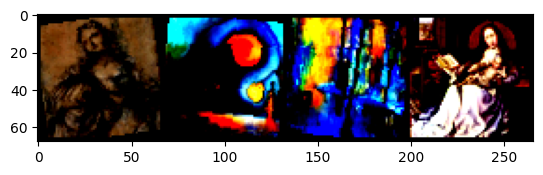

Labels: tensor([26,  8,  3, 26])


In [114]:
import matplotlib.pyplot as plt
import numpy as np
import torchvision

# Function to show an image
def imshow(img, title=None):
    #img = img / 2 + 0.5  # Unnormalize (assuming normalization is done earlier)
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    if title:
        plt.title(title)
    plt.show()

# Get a batch of training data
data_iter = iter(train_loader)
images, labels = next(data_iter)

# Show a few images
imshow(torchvision.utils.make_grid(images[:4]))  # Show first 4 images in the batch
print('Labels:', labels[:4])


In [115]:
# Define the CNN architecture
class ArtStyleCNN(nn.Module):
    def __init__(self, num_classes=30):
        super(ArtStyleCNN, self).__init__()
        
        self.features = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(64),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(128),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(256),
            nn.Dropout(0.25),  # Regularization
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(256, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(512),
            nn.Dropout(0.25),  # Regularization
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(512 * 4 * 4, 1024),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(1024, num_classes)
        )
        
    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x


In [116]:
# Training function
def train_model(model, train_loader, test_loader, criterion, optimizer, num_epochs=10):
    best_acc = 0.0
    train_losses = []
    test_losses = []
    train_accuracies = []
    test_accuracies = []
    
    for epoch in range(num_epochs):
        # Training phase
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0
        
        for inputs, labels in tqdm(train_loader, desc=f'Epoch {epoch+1}/{num_epochs}'):
            inputs, labels = inputs.to(device), labels.to(device)
            
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()
        
        epoch_loss = running_loss / len(train_loader)
        epoch_acc = 100. * correct / total
        train_losses.append(epoch_loss)
        train_accuracies.append(epoch_acc)
        
        # Testing phase
        model.eval()
        test_loss = 0.0
        correct = 0
        total = 0
        
        with torch.no_grad():
            for inputs, labels in test_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                
                test_loss += loss.item()
                _, predicted = outputs.max(1)
                total += labels.size(0)
                correct += predicted.eq(labels).sum().item()
        
        test_loss = test_loss / len(test_loader)
        test_acc = 100. * correct / total
        test_losses.append(test_loss)
        test_accuracies.append(test_acc)
        
        # Save best model
        if test_acc > best_acc:
            best_acc = test_acc
            torch.save(model.state_dict(), 'best_art_style_cnn.pth')
        
        print(f'Epoch {epoch+1}/{num_epochs}:')
        print(f'Train Loss: {epoch_loss:.4f}, Train Acc: {epoch_acc:.2f}%')
        print(f'Test Loss: {test_loss:.4f}, Test Acc: {test_acc:.2f}%')
        print(f'Best Test Acc: {best_acc:.2f}%')
        print('-' * 60)
    
    return train_losses, test_losses, train_accuracies, test_accuracies


In [117]:
# Initialize model, loss function, and optimizer
model = ArtStyleCNN().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)  # Added weight decay

In [118]:
# Train the model
train_losses, test_losses, train_accuracies, test_accuracies = train_model(
    model, train_loader, test_loader, criterion, optimizer, num_epochs=30  # Increased epochs
)

Epoch 1/30:   0%|          | 0/243 [00:00<?, ?it/s]

Epoch 1/30:
Train Loss: 2.4650, Train Acc: 31.69%
Test Loss: 5.0530, Test Acc: 26.30%
Best Test Acc: 26.30%
------------------------------------------------------------


Epoch 2/30:   0%|          | 0/243 [00:00<?, ?it/s]

Epoch 2/30:
Train Loss: 1.7626, Train Acc: 43.72%
Test Loss: 3.2366, Test Acc: 40.67%
Best Test Acc: 40.67%
------------------------------------------------------------


Epoch 3/30:   0%|          | 0/243 [00:00<?, ?it/s]

Epoch 3/30:
Train Loss: 1.5955, Train Acc: 49.18%
Test Loss: 4.4329, Test Acc: 36.80%
Best Test Acc: 40.67%
------------------------------------------------------------


Epoch 4/30:   0%|          | 0/243 [00:00<?, ?it/s]

Epoch 4/30:
Train Loss: 1.4891, Train Acc: 51.57%
Test Loss: 4.2319, Test Acc: 42.90%
Best Test Acc: 42.90%
------------------------------------------------------------


Epoch 5/30:   0%|          | 0/243 [00:00<?, ?it/s]

Epoch 5/30:
Train Loss: 1.4082, Train Acc: 53.63%
Test Loss: 4.2521, Test Acc: 47.30%
Best Test Acc: 47.30%
------------------------------------------------------------


Epoch 6/30:   0%|          | 0/243 [00:00<?, ?it/s]

Epoch 6/30:
Train Loss: 1.3501, Train Acc: 55.76%
Test Loss: 5.8095, Test Acc: 43.93%
Best Test Acc: 47.30%
------------------------------------------------------------


Epoch 7/30:   0%|          | 0/243 [00:00<?, ?it/s]

Epoch 7/30:
Train Loss: 1.2787, Train Acc: 57.80%
Test Loss: 3.8898, Test Acc: 51.40%
Best Test Acc: 51.40%
------------------------------------------------------------


Epoch 8/30:   0%|          | 0/243 [00:00<?, ?it/s]

Epoch 8/30:
Train Loss: 1.2436, Train Acc: 58.62%
Test Loss: 3.3965, Test Acc: 50.47%
Best Test Acc: 51.40%
------------------------------------------------------------


Epoch 9/30:   0%|          | 0/243 [00:00<?, ?it/s]

Epoch 9/30:
Train Loss: 1.2059, Train Acc: 59.66%
Test Loss: 3.1382, Test Acc: 51.50%
Best Test Acc: 51.50%
------------------------------------------------------------


Epoch 10/30:   0%|          | 0/243 [00:00<?, ?it/s]

Epoch 10/30:
Train Loss: 1.1580, Train Acc: 60.63%
Test Loss: 2.8744, Test Acc: 54.03%
Best Test Acc: 54.03%
------------------------------------------------------------


Epoch 11/30:   0%|          | 0/243 [00:00<?, ?it/s]

Epoch 11/30:
Train Loss: 1.1730, Train Acc: 61.36%
Test Loss: 6.2620, Test Acc: 48.93%
Best Test Acc: 54.03%
------------------------------------------------------------


Epoch 12/30:   0%|          | 0/243 [00:00<?, ?it/s]

Epoch 12/30:
Train Loss: 1.0817, Train Acc: 63.59%
Test Loss: 2.6727, Test Acc: 53.23%
Best Test Acc: 54.03%
------------------------------------------------------------


Epoch 13/30:   0%|          | 0/243 [00:00<?, ?it/s]

Epoch 13/30:
Train Loss: 1.0647, Train Acc: 63.67%
Test Loss: 2.9458, Test Acc: 52.33%
Best Test Acc: 54.03%
------------------------------------------------------------


Epoch 14/30:   0%|          | 0/243 [00:00<?, ?it/s]

Epoch 14/30:
Train Loss: 1.0447, Train Acc: 64.63%
Test Loss: 2.2357, Test Acc: 58.97%
Best Test Acc: 58.97%
------------------------------------------------------------


Epoch 15/30:   0%|          | 0/243 [00:00<?, ?it/s]

Epoch 15/30:
Train Loss: 1.0239, Train Acc: 65.67%
Test Loss: 2.9736, Test Acc: 54.73%
Best Test Acc: 58.97%
------------------------------------------------------------


Epoch 16/30:   0%|          | 0/243 [00:00<?, ?it/s]

Epoch 16/30:
Train Loss: 1.0043, Train Acc: 66.03%
Test Loss: 2.2640, Test Acc: 59.73%
Best Test Acc: 59.73%
------------------------------------------------------------


Epoch 17/30:   0%|          | 0/243 [00:00<?, ?it/s]

Epoch 17/30:
Train Loss: 1.0095, Train Acc: 66.12%
Test Loss: 2.1079, Test Acc: 60.20%
Best Test Acc: 60.20%
------------------------------------------------------------


Epoch 18/30:   0%|          | 0/243 [00:00<?, ?it/s]

Epoch 18/30:
Train Loss: 0.9458, Train Acc: 67.91%
Test Loss: 2.6303, Test Acc: 58.00%
Best Test Acc: 60.20%
------------------------------------------------------------


Epoch 19/30:   0%|          | 0/243 [00:00<?, ?it/s]

Epoch 19/30:
Train Loss: 0.9307, Train Acc: 68.73%
Test Loss: 2.0432, Test Acc: 61.47%
Best Test Acc: 61.47%
------------------------------------------------------------


Epoch 20/30:   0%|          | 0/243 [00:00<?, ?it/s]

Epoch 20/30:
Train Loss: 0.8929, Train Acc: 69.52%
Test Loss: 2.0385, Test Acc: 60.70%
Best Test Acc: 61.47%
------------------------------------------------------------


Epoch 21/30:   0%|          | 0/243 [00:00<?, ?it/s]

Epoch 21/30:
Train Loss: 0.8664, Train Acc: 70.71%
Test Loss: 1.9141, Test Acc: 60.67%
Best Test Acc: 61.47%
------------------------------------------------------------


Epoch 22/30:   0%|          | 0/243 [00:00<?, ?it/s]

Epoch 22/30:
Train Loss: 0.8594, Train Acc: 70.66%
Test Loss: 1.5189, Test Acc: 64.27%
Best Test Acc: 64.27%
------------------------------------------------------------


Epoch 23/30:   0%|          | 0/243 [00:00<?, ?it/s]

Epoch 23/30:
Train Loss: 0.8410, Train Acc: 71.72%
Test Loss: 3.5674, Test Acc: 59.10%
Best Test Acc: 64.27%
------------------------------------------------------------


Epoch 24/30:   0%|          | 0/243 [00:00<?, ?it/s]

Epoch 24/30:
Train Loss: 0.8131, Train Acc: 72.14%
Test Loss: 2.9778, Test Acc: 62.47%
Best Test Acc: 64.27%
------------------------------------------------------------


Epoch 25/30:   0%|          | 0/243 [00:00<?, ?it/s]

Epoch 25/30:
Train Loss: 0.7767, Train Acc: 73.63%
Test Loss: 1.4878, Test Acc: 64.07%
Best Test Acc: 64.27%
------------------------------------------------------------


Epoch 26/30:   0%|          | 0/243 [00:00<?, ?it/s]

Epoch 26/30:
Train Loss: 0.7585, Train Acc: 73.75%
Test Loss: 1.6481, Test Acc: 62.67%
Best Test Acc: 64.27%
------------------------------------------------------------


Epoch 27/30:   0%|          | 0/243 [00:00<?, ?it/s]

Epoch 27/30:
Train Loss: 0.7425, Train Acc: 74.80%
Test Loss: 1.6561, Test Acc: 64.20%
Best Test Acc: 64.27%
------------------------------------------------------------


Epoch 28/30:   0%|          | 0/243 [00:00<?, ?it/s]

Epoch 28/30:
Train Loss: 0.7213, Train Acc: 74.96%
Test Loss: 1.5827, Test Acc: 64.43%
Best Test Acc: 64.43%
------------------------------------------------------------


Epoch 29/30:   0%|          | 0/243 [00:00<?, ?it/s]

Epoch 29/30:
Train Loss: 0.6911, Train Acc: 76.47%
Test Loss: 1.6380, Test Acc: 64.37%
Best Test Acc: 64.43%
------------------------------------------------------------


Epoch 30/30:   0%|          | 0/243 [00:00<?, ?it/s]

Epoch 30/30:
Train Loss: 0.6851, Train Acc: 76.74%
Test Loss: 1.7250, Test Acc: 64.80%
Best Test Acc: 64.80%
------------------------------------------------------------


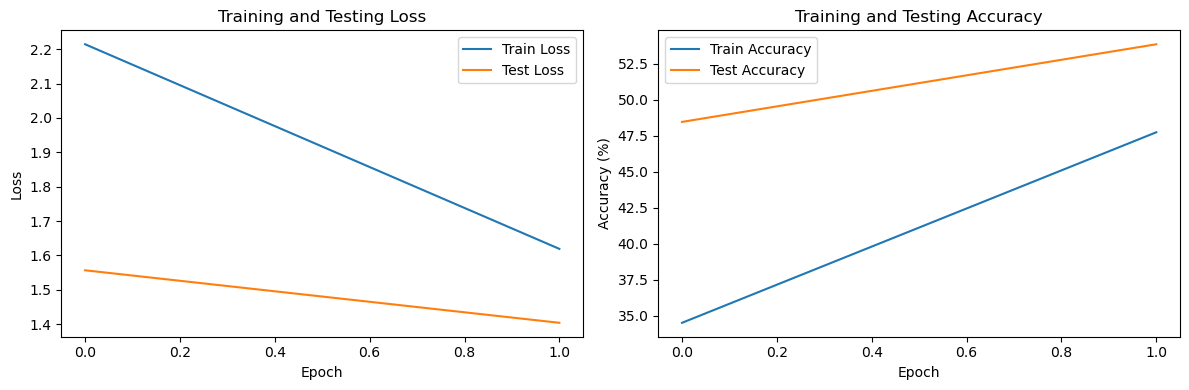

In [16]:
# Plot training and testing curves
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(test_losses, label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Testing Loss')

plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(test_accuracies, label='Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.title('Training and Testing Accuracy')

plt.tight_layout()
plt.show()


In [17]:
pip install opencv-python-headless

Note: you may need to restart the kernel to use updated packages.


/Users/tishyakasliwal/anaconda3/lib/python3.11/site-packages/torch/nn/modules/module.py:1640: FutureWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  self._maybe_warn_non_full_backward_hook(args, result, grad_fn)
/var/folders/2z/ssqbf1vd32x1pypcmcgd5k5m0000gn/T/ipykernel_39927/337138491.py:54: RuntimeWarning: invalid value encountered in divide
  cam = (cam - cam.min()) / (cam.max() - cam.min())  # Normalize to [0,1]
/var/folders/2z/ssqbf1vd32x1pypcmcgd5k5m0000gn/T/ipykernel_39927/337138491.py:57: RuntimeWarning: invalid value encountered in cast
  heatmap = cv2.applyColorMap(np.uint8(255 * cam), cv2.COLORMAP_JET)
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


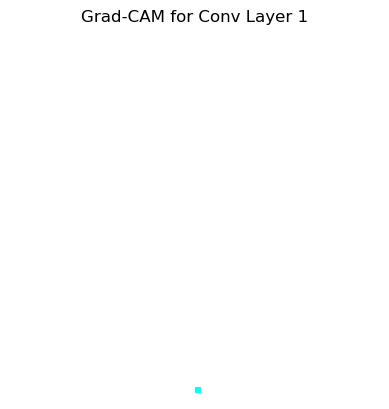

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


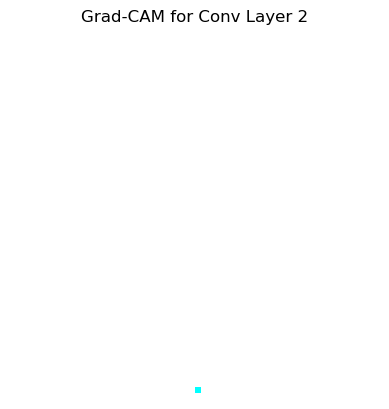

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


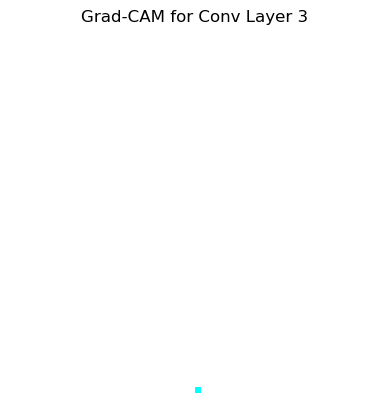

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


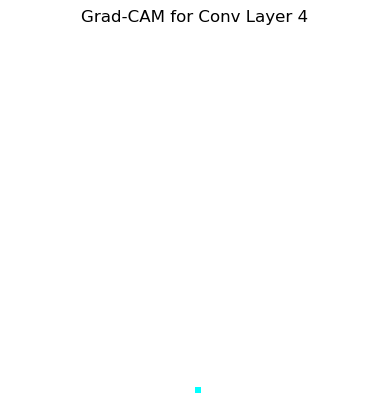

In [18]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import cv2
import matplotlib.pyplot as plt

def grad_cam(model, input_image, target_class):
    model.eval()
    
    # Dictionary to store activations and gradients
    activations = {}
    gradients = {}

    # Register hooks for each convolutional layer
    def forward_hook(module, input, output):
        activations[id(module)] = output.detach()

    def backward_hook(module, grad_in, grad_out):
        gradients[id(module)] = grad_out[0].detach()

    # Register hooks on each conv layer in model.features
    hooks = []
    for layer in model.features:
        if isinstance(layer, nn.Conv2d):
            hooks.append(layer.register_forward_hook(forward_hook))
            hooks.append(layer.register_backward_hook(backward_hook))

    # Forward pass
    output = model(input_image)
    
    # Zero gradients
    model.zero_grad()

    # Backward pass for the target class
    target = output[0, target_class]
    target.backward()

    # Compute Grad-CAM for each conv layer
    grad_cam_images = []
    for layer in model.features:
        if isinstance(layer, nn.Conv2d):
            # Get activations and gradients for the layer
            activation = activations[id(layer)]
            gradient = gradients[id(layer)]

            # Global average pool gradients over height and width
            weights = gradient.mean(dim=(2, 3), keepdim=True)
            cam = (weights * activation).sum(dim=1, keepdim=True).clamp(min=0)
            
            # Resize CAM to match input size
            cam = F.interpolate(cam, size=input_image.shape[2:], mode='bilinear', align_corners=False)
            cam = cam.squeeze().cpu().numpy()
            cam = (cam - cam.min()) / (cam.max() - cam.min())  # Normalize to [0,1]

            # Convert CAM to heatmap
            heatmap = cv2.applyColorMap(np.uint8(255 * cam), cv2.COLORMAP_JET)
            heatmap = cv2.cvtColor(heatmap, cv2.COLOR_BGR2RGB)
            
            # Overlay heatmap on the input image
            input_image_np = input_image.squeeze().permute(1, 2, 0).cpu().numpy()
            input_image_np = (input_image_np - input_image_np.min()) / (input_image_np.max() - input_image_np.min())
            overlay = heatmap * 0.4 + (input_image_np * 255).astype(np.uint8)
            grad_cam_images.append(overlay)
    
    # Remove hooks after use
    for hook in hooks:
        hook.remove()
    
    return grad_cam_images

# Example usage:
# Load an example input image and preprocess it
input_image = torch.randn(1, 3, 64, 64)  # Example input tensor
target_class = 0  # Example target class

# Initialize model and run Grad-CAM
#model = ArtStyleCNN(num_classes=30)
grad_cam_images = grad_cam(model, input_image, target_class)

# Display each Grad-CAM visualization
for i, cam_image in enumerate(grad_cam_images):
    plt.figure()
    plt.title(f"Grad-CAM for Conv Layer {i+1}")
    plt.imshow(cam_image)
    plt.axis('off')
    plt.show()


In [85]:

# Save the final model
torch.save(model.state_dict(), 'final_art_style_cnn.pth')